In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

%matplotlib inline
plt.style.use('seaborn')

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4416\2851211882.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
data = pd.read_csv("data/adult.csv")
data.head(5)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


Признаки:
* age - возраст
* workclass - статус занятости
* fnlwgt - общий вес, это число людей, которых, по мнению эксперта, представляет эта категория занятости
* education - образование
* education.num - образовательная ступень (в виде числа)
* marital.status - брачный статус
* occupation - профессия
* relationship - тип отношений
* race - раса
* sex - пол
* capital.gain - ежегодный дополнительный прирост капитала
* capital.loss - ежегодная дополнительная потеря капитала
* hours.per.week - число рабочих часов в неделю
* native.country - Родина 
* income - категория дохода (целевой признак)

In [3]:
data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [4]:
data.describe(include='object')

,workclass,education,marital.status,occupation,relationship,race,sex,native.country,income
count,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


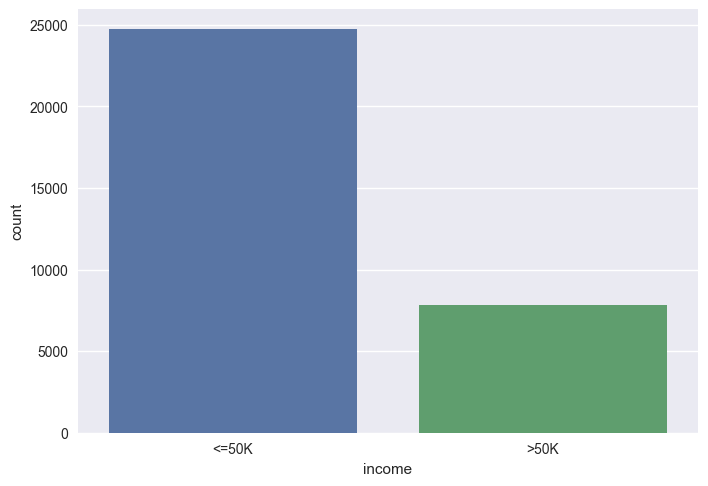

In [5]:
sns.countplot(data=data, x='income');

In [6]:
data['income'] = data['income'].apply(lambda x: 1 if x == '>50K' else 0)

In [7]:
types = data.dtypes
cat_features = list(types[(types == "object")].index)
cat_features

['workclass',
 'education',
 'marital.status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native.country']

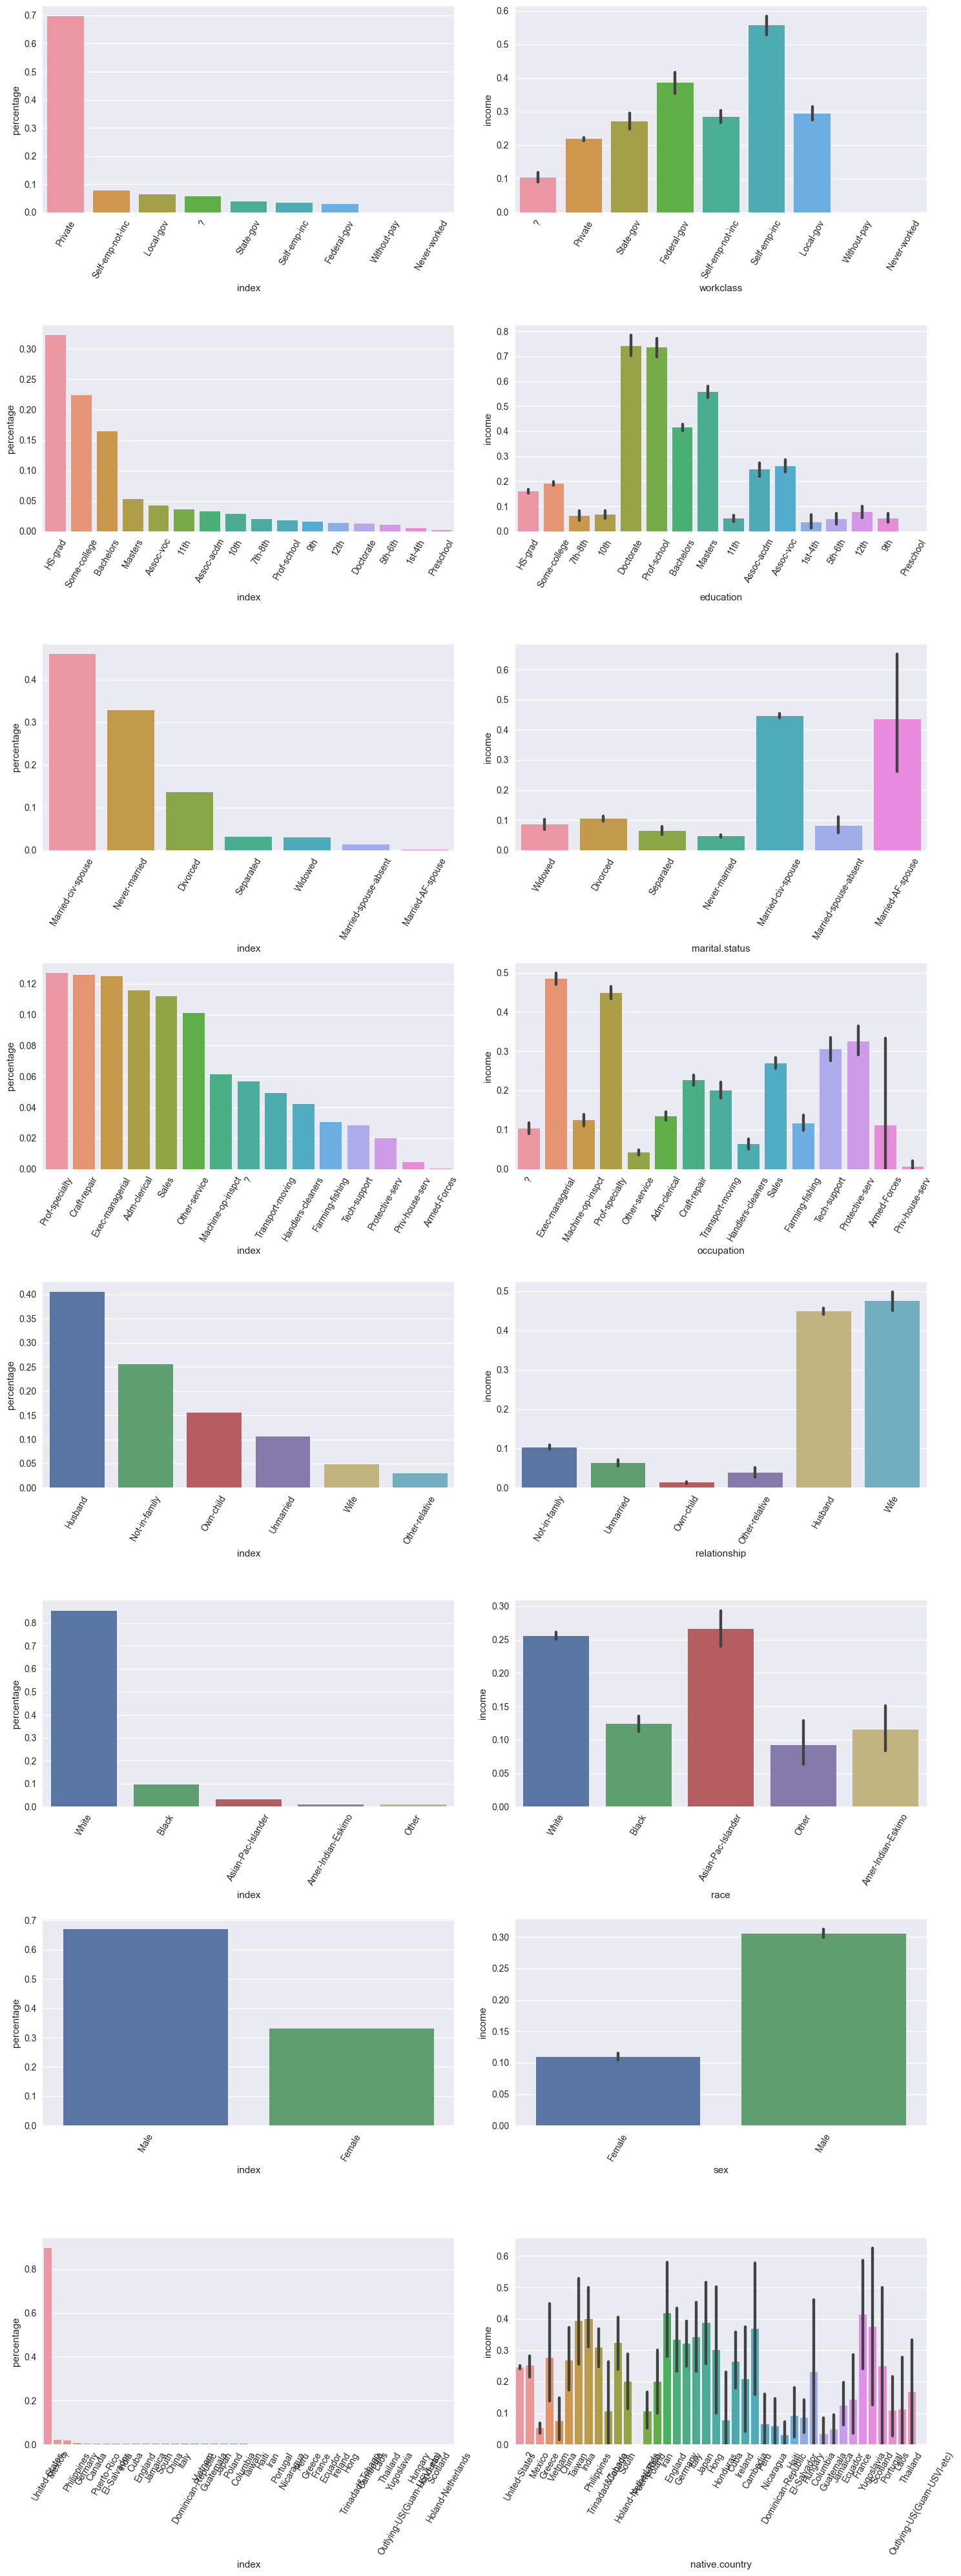

In [8]:
n = len(cat_features) #число категориальных признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 40)) #фигура+n*2 координатных плоскостей
#Создаем цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(cat_features):
    #Строим количественную столбчатую для долевого соотношения каждой из категорий в данных
    count_data = (data[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
    count_barplot = sns.barplot(data=count_data, x='index', y='percentage', ax=axes[i][0])
    count_barplot.xaxis.set_tick_params(rotation=60)
    #Строим столбчатую диаграмму доли людей зарабатывающих >50K (среднее по столбцу income) в зависимости от категории
    mean_barplot = sns.barplot(data=data, x=feature, y='income', ax=axes[i][1])
    mean_barplot.xaxis.set_tick_params(rotation=60)
plt.tight_layout() #выравнивание графиков

In [9]:
adult_data = data.copy()
#Определяем школьников в отдельную категорию
adult_data['education'] = adult_data['education'].apply(
    lambda x: 'School' if x == '11th' or x == '7th-8th' or x == '10th' 
        or x == '5th-6th' or x == '9th' or x == '12th' or x == '1st-4th' else x
)
#Объединяем категории Assoc-acdm и Assoc-voc (доценты)
adult_data['education'] = adult_data['education'].apply(
    lambda x: 'Associate' if x == 'Assoc-acdm' or x == 'Assoc-voc' else x
)
#Объединяем вдовцов,разведенных и живущих раздельно в одну категорию
adult_data['marital.status'] = adult_data['marital.status'].apply(
    lambda x: 'Prev-Married' if (x == 'Widowed' or x == 'Divorced' or x == 'Separated') else x
)
#Объединяем всех женатых/за мужем в одну категорию
adult_data['marital.status'] = adult_data['marital.status'].apply(
    lambda x: 'Married' if (x == 'Married-civ-spouse' or x == 'Married-spouse-absent' or x == 'Married-AF-spouse') else x
)
#Объединяем мужей и жен в одну категорию, остальных в другую
adult_data['relationship'] = adult_data['relationship'].apply(
    lambda x: 'In relationship' if (x == 'Husband' or x == 'Whife') else 'Not in relationship'
)

#Объединяем типы занятоностей, не приносящих дохода в одну категорию
adult_data['workclass'] = adult_data['workclass'].apply(
    lambda x: 'No income' if x == 'Never-worked' or x == 'Without-pay' else x
)
#Объединяем всех приезжих в одну категорию
adult_data['native.country'] = adult_data['native.country'].apply(
    lambda x: 'Other' if x != 'United-States' else x
)

предобрабатываем числовые признаки

In [10]:
adult_data['capital.gain'] = np.log(adult_data['capital.gain']+1)
adult_data['capital.loss'] = np.log(adult_data['capital.loss']+1)
adult_data['fnlwgt'] = np.log(adult_data['fnlwgt']+1)

#создаем новый признак разность между приростом капитала и его убылью
adult_data['capital_diff'] = abs((adult_data['capital.gain'] - adult_data['capital.loss']))

In [11]:
#удаляем ненужные признаки 
adult_data = adult_data.drop(['education.num', 'capital.gain', 'capital.loss'],axis=1)

In [12]:
adult_data.describe(include="object")

,workclass,education,marital.status,occupation,relationship,race,sex,native.country
count,32561,32561,32561,32561,32561,32561,32561,32561
unique,8,9,3,15,2,5,2,2
top,Private,HS-grad,Married,Prof-specialty,Not in relationship,White,Male,United-States
freq,22696,10501,15417,4140,19368,27816,21790,29170


In [13]:
import plotly
import plotly.express as px
fig1 = px.imshow(
    adult_data.corr(),
    title='мультиколинеарность и взаимосвязь с целевым признаком',
    height=800,
    width=1000,
    text_auto=True
)
fig1.show()

In [14]:
dummies_data = pd.get_dummies(adult_data,drop_first=True)
dummies_data.head()

,age,fnlwgt,hours.per.week,income,capital_diff,workclass_Federal-gov,workclass_Local-gov,workclass_No income,workclass_Private,workclass_Self-emp-inc,...,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Not in relationship,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male,native.country_United-States
0,90,11.252262,40,0,8.379539,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,1
1,82,11.797134,18,0,8.379539,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,1
2,66,12.133835,40,0,8.379539,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
3,54,11.851966,40,0,8.268988,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,1
4,41,12.486216,40,0,8.268988,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,1


In [15]:
#сохдаем матрицу наблюдений X и векторов Y
X = dummies_data.drop(['income'],axis=1)
y = dummies_data['income']

Разделяем выборку на тренировочную и тестовую в соотношении 80/20. Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение). 

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,random_state=1,test_size=0.2)

In [17]:
#производим нормализацию данных с помощью min_max нормализации

scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Логистическая регресия

Зафиксируем только метрики, которые были получены без дополнительной настройки, т.е со значениями гиперпараметров, установленных по умолчанию:

In [18]:
log_reg = linear_model.LogisticRegression(max_iter=1000)
#обучаем модель ,минимизирую logloss
log_reg.fit(X_train_scaled,y_train)
print("accuracy на тестовом наборе: {:.2f}".format(log_reg.score(X_test_scaled, y_test)))
y_test_pred = log_reg.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.84
f1_score на тестовом наборе: 0.64


### <center> **GridSearchCV**

Чтобы воспользоваться классом GridSearchCV:
- сначала необходимо импортировать библиотеку; 
- затем указать искомые гиперпараметры в виде словаря: ключами словаря являются имена настраиваемых гиперпараметров, а значениями – тестируемые настройки гиперпараметров; 
- после передаем модель (LogisticRegression), сетку искомых параметров (param_grid), а также число фолдов, которые мы хотим использовать в кросс-валидации, (допустим, пятиблочную кросс-валидацию, cv=5) и n_jobs = -1, чтобы использовать все доступные ядра для расчетов.

Созданный нами объект grid_search аналогичен классификатору, мы можем вызвать стандартные методы fit, predict и score от его имени. Однако, когда мы вызываем fit, он запускает кросс-валидацию для каждой комбинации гиперпараметров, указанных в param_grid.

GridSearchCV включает в себя не только поиск лучших параметров, но и автоматическое построение новой модели на всем обучающем наборе данных, используя параметры, которые дают наилучшее значение точности при кросс-валидации.


In [19]:
from sklearn.model_selection import GridSearchCV

param_grid = {'penalty': ['l2', 'none'] ,#тип регурялизации
              'solver': ['lbfgs', 'saga'], #алгоритм оптимизации
              }
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, #генератор случайных чисел
        max_iter=1000 #количество итераций на сходимость
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test_scaled, y_test)))
y_test_pred = grid_search.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.



CPU times: total: 891 ms
Wall time: 52.5 s
accuracy на тестовом наборе: 0.84
f1_score на тестовом наборе: 0.64
Наилучшие значения гиперпараметров: {'penalty': 'none', 'solver': 'lbfgs'}


In [20]:
param_grid = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]
grid_search_1 = GridSearchCV(
    estimator = linear_model.LogisticRegression(random_state=1,max_iter=1000),
    param_grid=param_grid,
    cv=5,
    n_jobs= -1
)
%time grid_search_1.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_1.score(X_test_scaled, y_test)))
y_test_pred = grid_search_1.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_1.best_params_))

CPU times: total: 766 ms
Wall time: 4min 23s
accuracy на тестовом наборе: 0.84
f1_score на тестовом наборе: 0.64
Наилучшие значения гиперпараметров: {'C': 0.3, 'penalty': 'l2', 'solver': 'lbfgs'}


**Метрику опять не удалось улучшить, а время потратили много, в 5 раз больше!**

Поиск по сетке не гарантирует, что мы найдем наилучшую комбинацию гиперпараметров, а все потому что сетка значений конечна и фактическое наилучшее значение может отсутствовать или оказаться между значений, заданными нами.

Ознакомиться с итоговой полученной моделью можно с помощью best_estimator_. 

In [21]:
print("Наилучшая модель:\n{}".format(grid_search.best_estimator_))

Наилучшая модель:
LogisticRegression(max_iter=1000, penalty='none', random_state=42)


А наилучшее значение точности кросс-валидации (значение точности, усредненное по всем разбиениям для данной комбинации гиперпараметров) – в атрибуте best_score_. 

**не путайте best_score_ со значением точности модели, которое вычисляется на тестовом наборе с помощью метода score. Метод score (оценивающий качество результатов, полученных с помощью метода predict) использует модель, построенную на всем обучающем наборе данных. В атрибуте best_score_ записывается средняя точность кросс-валидации. Для ее вычисления используется модель, построенная на обучающем наборе кросс-валидации.

In [22]:
print("Наилучшее значение точности при кросс-валидаци: {:.2f}".format(grid_search.best_score_))

Наилучшее значение точности при кросс-валидаци: 0.84


In [23]:
# Взглянем на результаты кросс-валидации
result_cv = pd.DataFrame(grid_search_1.cv_results_)
result_cv.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.174921,0.023870,0.004671,0.002719,0.01,l2,lbfgs,"{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}",0.838004,0.833781,0.838004,0.839317,0.836437,0.837108,0.001897,51
1,0.334966,0.041173,0.003229,0.001064,0.01,l2,sag,"{'C': 0.01, 'penalty': 'l2', 'solver': 'sag'}",0.838004,0.833781,0.838004,0.839317,0.836437,0.837108,0.001897,51
2,1.170237,0.146690,0.001902,0.001280,0.01,none,lbfgs,"{'C': 0.01, 'penalty': 'none', 'solver': 'lbfgs'}",0.843570,0.840115,0.841843,0.845652,0.844884,0.843213,0.002017,8
3,22.716904,0.323810,0.003827,0.001660,0.01,none,sag,"{'C': 0.01, 'penalty': 'none', 'solver': 'sag'}",0.843570,0.840115,0.841843,0.845652,0.844692,0.843174,0.001986,18
4,0.192080,0.014750,0.002500,0.000317,0.1,l2,lbfgs,"{'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}",0.842226,0.840691,0.842802,0.843732,0.841620,0.842214,0.001032,45
5,0.388640,0.019513,0.002433,0.000396,0.1,l2,sag,"{'C': 0.1, 'penalty': 'l2', 'solver': 'sag'}",0.842226,0.840691,0.842802,0.843732,0.841620,0.842214,0.001032,45
6,1.018708,0.147741,0.002281,0.000403,0.1,none,lbfgs,"{'C': 0.1, 'penalty': 'none', 'solver': 'lbfgs'}",0.843570,0.840115,0.841843,0.845652,0.844884,0.843213,0.002017,8
7,22.949353,1.146818,0.003613,0.001872,0.1,none,sag,"{'C': 0.1, 'penalty': 'none', 'solver': 'sag'}",0.843570,0.840115,0.841843,0.845652,0.844692,0.843174,0.001986,18
8,0.271923,0.029988,0.003125,0.001687,0.3,l2,lbfgs,"{'C': 0.3, 'penalty': 'l2', 'solver': 'lbfgs'}",0.843378,0.840691,0.842610,0.846228,0.843540,0.843289,0.001784,1
9,0.510474,0.039705,0.002586,0.000549,0.3,l2,sag,"{'C': 0.3, 'penalty': 'l2', 'solver': 'sag'}",0.843378,0.840691,0.842610,0.846228,0.843540,0.843289,0.001784,1


In [24]:
visual = pd.pivot_table(pd.DataFrame(grid_search_1.cv_results_),
                        values="mean_test_score",
                        index="param_C",
                        columns="param_solver")
fig2 = px.imshow(visual,
                 title='Тепловая карта зависимости метрики accuracy от solver и С',
                 height=600,
                 width=800,
                 text_auto=True)
fig2.show()

Видим, что слабая регуляризация С = 0,01 отрицательно влияет на метрику, поэтому есть смысл брать значения больше 0,5 и  алгоритмы оптимизации lbfgs и sag работают лучше.

## <center> **RandomizedSearchCV**

В отличие от GridSearchCV, не все комбинации гиперпараметров проверяются, а только заданное количество комбинаций выбирается из указанных распределений. Количество комбинаций гиперпараметров задается n_iter.

С использованием класса RandomizedSearchCV из библиотеки scikit learn мы осуществим оптимизацию гиперпараметров для алгоритмов логистической регрессии, дерева решений и случайного леса, а также сравним результаты с GridSearchCV и значениями по умолчанию.

Основные параметры RandomizedSearchCV аналогичны GridSearchCV, за исключением наименований некоторых параметров и наличия параметра n_iter:
- **estimator** — алгоритм, который будем оптимизировать;
- **param_distributions** — cловарь с именами параметров (str) в качестве ключей и списками параметров в качестве значений, которые нужно попробовать.
- **scoring** — по умолчанию используется score-функция заданного алгоритма:
    - для классификации — sklearn.metrics.accuracy_score;
    - для регрессии — sklearn.metrics.r2_score.
- **cv** — количество фолдов в кросс-валидации, по умолчанию используется 5.
- **n_jobs** — количество ядер для распараллеливания расчёта. -1 использует все существующие ядра.
- **n_iter** — количество комбинаций на расчёт. От этого параметра напрямую зависит время оптимизации и качество модели.

In [25]:
from sklearn.model_selection import RandomizedSearchCV
#np.linspace(start(от), stop(до), num=50(количество),dtype-тип данных)
param_distributions = {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))}
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
 
 
random_search.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(random_search.score(X_test_scaled, y_test)))
y_test_pred = random_search.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

#Затраченное время: 2 min 20s
#accuracy на тестовом наборе: 0.84
#f1_score на тестовом наборе: 0.64
#Наилучшие значения параметров: {'solver': 'sag', 'penalty': 'l2', 'C': 0.89}

accuracy на тестовом наборе: 0.84
f1_score на тестовом наборе: 0.64
Наилучшие значения гиперпараметров: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.89}


In [26]:
param_grid = {"penalty":["12","none"],
              "solver":["lbfgs","sag"],
              "C":list(np.linspace(0.01,10,10,dtype=float))}

grid_search_2 = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42,max_iter=1000),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)

%time grid_search_2.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_2.score(X_test_scaled, y_test)))
y_test_pred = grid_search_2.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_2.best_params_))

c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning:


100 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base

CPU times: total: 1.02 s
Wall time: 5min 11s
accuracy на тестовом наборе: 0.84
f1_score на тестовом наборе: 0.64
Наилучшие значения гиперпараметров: {'C': 0.01, 'penalty': 'none', 'solver': 'lbfgs'}


### Дерево решений

Проделаем аналогичное для DecisionTreeClassifier().
Сначала посчитаем модель с параметрами по умолчанию и оценим метрику:

In [27]:
#Создаем объект класса дерево решений
dt = tree.DecisionTreeClassifier(random_state=42)
#Обучаем дерево по алгоритму CARTrint
dt.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_train_pred = dt.predict(X_train_scaled)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = dt.predict(X_test_scaled)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 1.00
Test: 0.62


Теперь зададим сетку гиперпараметров:  
*  'min_samples_leaf' - минимальное количество объектов в листе;
*  'max_depth': максимальная глубина дерева, не должна быть слишком большой, иначе будет переобучение;
*  'criterion' - критерий информативности

И посчитаем RandomizedSearchCV() и затем GridSearchCV()


In [28]:
param_distributions = {'min_samples_leaf': list(np.linspace(5, 100, 50, dtype=int)),
              'max_depth': list(np.linspace(1, 30, 50, dtype=int)),
              'criterion':['entropy','gini']
              }
            
random_search_tree = RandomizedSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 50, 
    n_jobs = -1
)  
%time random_search_tree.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(random_search_tree.score(X_test_scaled, y_test)))
y_test_pred = random_search_tree.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_tree.best_params_))

CPU times: total: 391 ms
Wall time: 14.2 s
accuracy на тестовом наборе: 0.86
f1_score на тестовом наборе: 0.66
Наилучшие значения гиперпараметров: {'min_samples_leaf': 36, 'max_depth': 20, 'criterion': 'entropy'}


In [29]:
param_grid = {'min_samples_leaf': list(np.linspace(5, 100, 50, dtype=int)),
              'max_depth': list(np.linspace(1, 30, 50, dtype=int)),
              'criterion':['entropy','gini']
              }
            
grid_search_tree = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_grid= param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_tree.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_tree.score(X_test_scaled, y_test)))
y_test_pred = grid_search_tree.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))

KeyboardInterrupt: 

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [31]:
param_distributions = {'min_samples_leaf': list(np.linspace(100, 200, 30, dtype=int)),
              'min_samples_leaf': [5, 7],
              "max_depth" : [10, 15, 20, 25]
              }
            
random_search_tree = RandomizedSearchCV(
    estimator= ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search_tree.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(random_search_tree.score(X_test_scaled, y_test)))
y_test_pred = random_search_tree.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_tree.best_params_))

c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning:

The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.



CPU times: total: 1.7 s
Wall time: 59.2 s
accuracy на тестовом наборе: 0.86
f1_score на тестовом наборе: 0.67
Наилучшие значения гиперпараметров: {'min_samples_leaf': 5, 'max_depth': 20}


In [32]:
param_distributions = {'min_samples_leaf': list(np.linspace(100, 200, 30, dtype=int)),
              'min_samples_leaf': [5, 7],
              "max_depth" : [10, 15, 20, 25]
              }
            
random_search_tree = RandomizedSearchCV(
    estimator= ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5, 
    n_jobs = -1
)  
%time random_search_tree.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(random_search_tree.score(X_test_scaled, y_test)))
y_test_pred = random_search_tree.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_tree.best_params_))

c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning:

The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.



CPU times: total: 1.73 s
Wall time: 48.6 s
accuracy на тестовом наборе: 0.86
f1_score на тестовом наборе: 0.67
Наилучшие значения гиперпараметров: {'min_samples_leaf': 5, 'max_depth': 20}


## <center> РЕКОМЕНДАЦИИ ПО НАСТРОЙКЕ ГИПЕРПАРАМЕТРОВ АНСАМБЛЕЙ НАД РЕШАЮЩИМИ ДЕРЕВЬЯМИ

### АЛГОРИТМ СЛУЧАЙНОГО ЛЕСА (RANDOMFOREST)

* n_estimators — число итераций (количество деревьев). Частично работает правило «чем больше, тем лучше», но иногда это не имеет особого смысла и сильно увеличивает затраты, поэтому стоит пробовать обучать сотни деревьев [100,200, 300, 400]. Если нет изменений, то оставить минимальное — 100.
* max_depth — максимальная глубина дерева. В случайном лесе строятся «сильные» деревья, каждое из которых даёт полноценный прогноз, поэтому глубина деревьем может быть достаточно большой. Стоит следить за переобучением.
* max_features — максимальное количество признаков, учитываемых алгоритмом при поиске лучшего разделения;
* subsample — доля выборки, которая будет использоваться для обучения каждого алгоритма — дерева.
Примечание. Так как алгоритм градиентного бустинга мы ещё не проходили, вы можете вернуться в данный раздел, когда изучите модуль ML-8.

### АЛГОРИТМ ГРАДИЕНТНОГО БУСТИНГА (GRADIENTBOOSTING)

* n_estimators — число итераций (количество деревьев) : хотя ошибка на обучении монотонно стремится к нулю, ошибка на контроле, как правило, начинает увеличиваться после определенной итерации. Оптимальное число итераций можно выбирать, например, по отложенной выборке или с помощью кросс-валидации.
* learning_rate — темп обучения (0;1]:

На практике оказывается, что градиентный бустинг очень быстро строит композицию, ошибка которой на обучении выходит на асимптоту (достигает предела), после чего начинает настраиваться на шум и переобучаться. Параметр learning_rate контролирует, насколько сильно каждое дерево будет пытаться исправить ошибки предыдущих деревьев. Более высокая скорость обучения означает, что каждое дерево может внести более сильные корректировки. Как правило, чем меньше темп обучения, тем лучше качество итоговой композиции.

* max_depth — максимальная глубина дерева. Используется для борьбы с переобучением. Рекомендуется устанавливать не более 5.
* max_features — максимальное количество признаков, учитываемых алгоритмом при поиске лучшего разделения.
* subsample — доля выборки, которая будет использоваться для обучения каждого алгоритма. Это ещё один способ улучшения качества градиентного бустинга. Таким образом вносится рандомизация в процесс обучения базовых алгоритмов, что снижает уровень шума в обучении, а также повышает эффективность вычислений. 
Рекомендация. Берите подвыборки, размер которых вдвое меньше исходной выборки.



Главное отличие техник Bagging и Boosting состоит в параллельном и последовательном построении деревьев соответственно.

Основные параметры градиентного бустинга деревьев — это количество деревьев (n_estimators) и скорость обучения (learning_rate), контролирующие степень вклада каждого дерева в устранение ошибок предыдущих деревьев. Эти два параметра тесно взаимосвязаны, поскольку более низкое значение learning_rate означает, что для построения модели аналогичной сложности необходимо большее количество деревьев.

В отличие от случайного леса, в котором более высокое значение n_estimators всегда дает лучшее качество, увеличение значения n_estimators в градиентном бустинге даёт более сложную модель, что может привести к переобучению. При всём этом случайный лес, в отличие от градиентного бустинга, использует глубокие деревья, способные сформировать полноценный прогноз. 

Общепринятая практика для бустинга — подгонять n_estimators в зависимости от бюджета времени и памяти, а затем подбирать различные значения learning_rate.